# **Instalación de Herramientas y el Juego**

En este proceso, descargamos todo lo necesario para que funcione el laboratorio.

Instalamos las librerías de Inteligencia Artificial.

Importante: Instalamos el emulador de Atari (ALE) y las "ROMs" (los archivos del juego), ya que Freeway es un juego de consola antigua.

In [1]:
# Esta línea instala las herramientas básicas de TensorFlow y agentes.
!pip install -q tf-agents[reverb]

# Esta línea instala el emulador de juegos de Atari.
!pip install -q gymnasium[atari]
!pip install -q gymnasium[accept-rom-license]

# Esta línea instala herramientas para manejar las imágenes del juego.
!pip install -q imageio
!pip install -q pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 11.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 86.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 102.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

# **Importar Librerías y Configurar Pantalla**

En este proceso, traemos las herramientas al taller y preparamos el monitor virtual.

Importamos TensorFlow y las herramientas para crear redes neuronales que "ven" imágenes (Convolucionales).

Activamos una pantalla virtual oculta para que el juego pueda "dibujarse" aunque no tengamos un monitor físico conectado.

In [2]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pyvirtualdisplay

# Esta línea inicia una pantalla virtual para que el juego pueda generar imágenes internamente.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900))
display.start()

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_atari
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


2025-11-22 10:03:30.076528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-22 10:03:30.076584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-22 10:03:30.078321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Esta línea define cuántas veces va a entrenar.
num_iterations = 25000 

# Pasos iniciales al azar.
initial_collect_steps = 2000 

# Pasos por vuelta de entrenamiento.
collect_steps_per_iteration = 1

# Tamaño de memoria.
replay_buffer_max_length = 100000

# Tamaño del lote.
batch_size = 64


learning_rate = 2.5e-4

# Intervalos de log visuales.
log_interval = 200
num_eval_episodes = 5
eval_interval = 10000

In [4]:
# Esta línea define el nombre del juego.
env_name = 'Freeway-v4'

# --- CARGA DEL ENTORNO ---
# Usamos suite_atari que ya viene preparado para trabajar con gym 0.21.0
# Incluye automáticamente el apilado de 4 frames y la escala de grises.
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=2000,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=2000,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

# Convertimos a TensorFlow
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

print('Observation Spec:', train_env.observation_spec())
print('Action Spec:', train_env.action_spec())

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation Spec: BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8))
Action Spec: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))


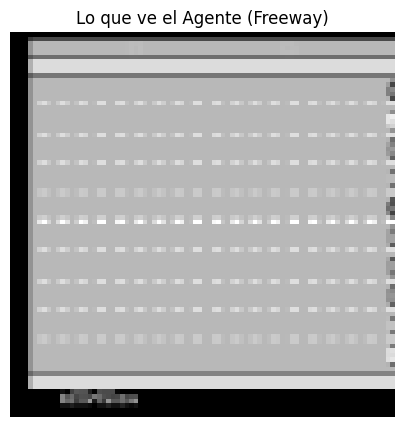

In [5]:
# Esta línea resetea el entorno para empezar de cero.
time_step = eval_env.reset()

# Esta línea toma la imagen actual del juego (en formato de números).
observation = time_step.observation.numpy()[0]

# Esta línea nos prepara un "lienzo" para dibujar.
plt.figure(figsize=(5, 5))

# Esta línea dibuja la imagen. Nota: Mostramos solo el primer frame de los 4 apilados.
# Verás los carriles y quizás al pollo (un punto brillante) abajo.
plt.imshow(observation[:, :, 0], cmap='gray')
plt.title("Lo que ve el Agente (Freeway)")
plt.axis('off')
plt.show()

In [6]:
# Definimos la estructura visual
conv_layer_params = [(32, 8, 4), (64, 4, 2), (64, 3, 1)]
fc_layer_params = (512,)

# Capa de preprocesamiento (Enteros -> Decimales)
preprocessing_layer = tf.keras.layers.Lambda(
    lambda obs: tf.cast(obs, tf.float32) / 255.0)

# Creamos la red Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


input_shape = (1,) + train_env.observation_spec().shape
dummy_input = tf.zeros(input_shape, dtype=tf.uint8)


print(f"Inicializando red manualmente con forma: {input_shape}...")
_ = q_net(dummy_input)
print("¡Red inicializada y dimensiones fijadas correctamente!")

Inicializando red manualmente con forma: (1, 84, 84, 4)...
¡Red inicializada y dimensiones fijadas correctamente!


In [7]:

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=10.0)

train_step_counter = tf.Variable(0)

# Usamos DQN estándar
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    # Usamos Huber Loss en lugar de Squared Loss porque es más resistente a errores grandes
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

# **Configuración de la Memoria**

En este proceso, se prepara el almacenamiento de recuerdos.

Como son imágenes, ocupan mucho espacio, así que la gestión de memoria es vital.

Se define también la función para calcular el puntaje promedio (cuántas veces cruza la calle el pollo).

In [8]:
# Esta función calcula el puntaje promedio jugando varias partidas.
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# Esta línea crea el buffer de memoria para guardar las partidas y aprender de ellas.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [9]:
import gym
from tf_agents.environments import gym_wrapper
from tf_agents.environments import tf_py_environment
from tf_agents.environments import atari_preprocessing
from tf_agents.environments import atari_wrappers
from tf_agents.drivers import dynamic_step_driver



class AtariCompatWrapper(gym.Wrapper):
    def step(self, action):
        val = self.env.step(action)
        # Si devuelve 5 valores (nuevo API), los convertimos a 4 (viejo API).
        if len(val) == 5:
            obs, reward, terminated, truncated, info = val
            return obs, reward, terminated or truncated, info
        return val

    def reset(self, **kwargs):
        val = self.env.reset(**kwargs)
        # Si devuelve tupla (obs, info), nos quedamos solo con obs.
        if isinstance(val, tuple) and len(val) == 2:
            return val[0]
        return val

def create_robust_atari_env(env_name):
    # 1. Creamos el entorno y le quitamos TODOS los wrappers automáticos (.unwrapped)
    # Esto elimina al culpable del error (OrderEnforcing) que estaba fallando antes.
    raw_env = gym.make(env_name).unwrapped
    
    # 2. Aplicamos nuestro parche inmediatamente al núcleo
    env = AtariCompatWrapper(raw_env)
    
    # 3. Re-aplicamos el límite de tiempo (vital para que los episodios terminen)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=2000)
    
    # 4. Aplicamos el preprocesamiento estándar de Atari (Gris, Resize 84x84)
    env = atari_preprocessing.AtariPreprocessing(env)
    
    # 5. Apilamos los frames (para detectar velocidad y dirección)
    env = atari_wrappers.FrameStack4(env)
    
    # 6. Convertimos a TF-Agents
    return gym_wrapper.GymWrapper(env)

# --- CARGA DE ENTORNOS ---
print(f"Reconstruyendo entorno {env_name} desde el núcleo...")
py_env_train = create_robust_atari_env(env_name)
py_env_eval = create_robust_atari_env(env_name)

# Convertimos a TensorFlow Environment
train_env = tf_py_environment.TFPyEnvironment(py_env_train)
eval_env = tf_py_environment.TFPyEnvironment(py_env_eval)

# ---------------------------------------------------------
# Ejecución de la Recolección
# ---------------------------------------------------------

# Creamos el conductor
collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=initial_collect_steps)

print("Iniciando recolección de datos...")
collect_driver.run()
print("¡Recolección finalizada con éxito!")

# Preparamos los datos para el entrenamiento
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Reconstruyendo entorno Freeway-v4 desde el núcleo...
Iniciando recolección de datos...


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment Freeway-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Freeway-v5`.
  logger.warn(


¡Recolección finalizada con éxito!
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [10]:
import time
import sys


collect_driver_training = dynamic_step_driver.DynamicStepDriver(
    train_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration) # <-- Aquí está la clave: 1 paso, no 2000.

# 2. Configuramos intervalos de impresión para calmar la ansiedad
log_interval = 100   # Imprimir error cada 100 pasos
eval_interval = 1000 # Evaluar cada 1000 pasos

# Optimizamos
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

# Reset de métricas
print("Evaluando agente antes de empezar...")
avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
returns = [avg_return]
print(f'Retorno inicial: {avg_return}')

print("--- INICIO DEL ENTRENAMIENTO VELOZ ---")
start_time = time.time()

for _ in range(num_iterations):

  # 1. Recolectar (¡Ahora es rápido! Solo 1 paso)
  collect_driver_training.run()

  # 2. Muestrear datos
  experience, _ = next(iterator)

  # 3. Entrenar
  train_loss = agent.train(experience).loss

  # Obtener paso actual
  step = agent.train_step_counter.numpy()

  # --- IMPRESIÓN CONSTANTE DE PROGRESO ---
  # Imprimimos cada 10 pasos para que veas que no está colgado
  if step % 100 == 0:
      elapsed = time.time() - start_time
      # Usamos sys.stdout para forzar la impresión inmediata
      print(f'\rIteración: {step} | Loss: {train_loss:.3f} | Tiempo: {elapsed:.1f}s', end='')

  # Guardar log oficial cada log_interval
  if step % log_interval == 0:
      print(f'\n[Log] Paso {step}: Loss final = {train_loss:.4f}')

  # Evaluar rendimiento
  if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, eval_policy, num_eval_episodes)
      print(f'\n--- EVALUACIÓN Paso {step}: Puntos Promedio = {avg_return} ---')
      returns.append(avg_return)

print("\n¡Entrenamiento finalizado!")

Evaluando agente antes de empezar...
Retorno inicial: 16.200000762939453
--- INICIO DEL ENTRENAMIENTO VELOZ ---
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Iteración: 100 | Loss: 633.017 | Tiempo: 9.1s
[Log] Paso 100: Loss final = 633.0171
Iteración: 200 | Loss: 10494.729 | Tiempo: 17.0s
[Log] Paso 200: Loss final = 10494.7295
Iteración: 300 | Loss: 3834.484 | Tiempo: 24.8s
[Log] Paso 300: Loss final = 3834.4844
Iteración: 400 | Loss: 7060.281 | Tiempo: 32.8s
[Log] Paso 400: Loss final = 7060.2812
Iteración: 500 | Loss: 133020.375 | Tiempo: 40.7s
[Log] Paso 500: Loss final = 133020.3750
Iteración: 600 | Loss: 73747.508 | Tiempo: 48.4s
[Log] Paso 600: Loss final = 73747.5078
Iteración: 700 | Loss: 671060.500 | Tiempo: 56.1s
[Log] Paso 700: Loss final = 671060.5000
Iteración: 800 | Loss: 288653.500 | Tiempo: 63.7s
[Log] Paso 800: Loss final = 288653.5000
Iteración: 900 | Loss: 837489.500 | Tiempo: 71.5s
[Log] Paso 900: Loss final = 837489.5000
Iteración: 1000 | Loss: 30931894.000 | Tiempo: 79.3s
[Log] Paso 1000: Loss final = 30931894.0000

--- EVALUACIÓN Paso 1000: Puntos Promedio = 0.0 ---
Iteración: 1100 | Loss: 1723195.500 | Tiempo: 117.

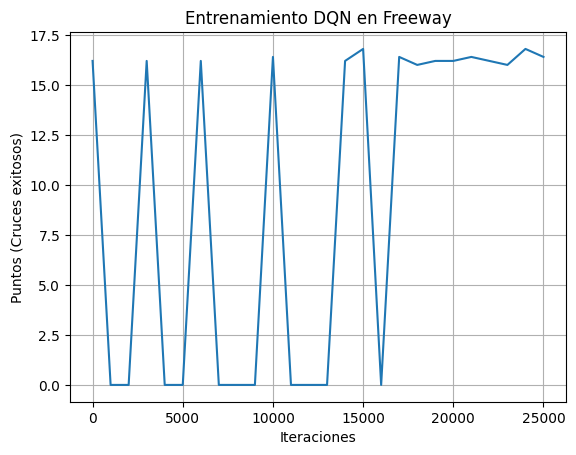

In [11]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Puntos (Cruces exitosos)')
plt.xlabel('Iteraciones')
plt.title("Entrenamiento DQN en Freeway")
plt.grid(True)
plt.show()

# **Interpretación de los Resultados (El Pollo vs. Tráfico)**

En este proceso, miramos la gráfica final para ver si el entrenamiento valió la pena.

La Oscilación (Subidas y bajadas): Durante gran parte del entrenamiento, verás que la línea sube y baja bruscamente. Esto es normal en Freeway; significa que el agente a veces tiene "racha" y cruza rápido, y otras veces se queda atascado dudando, oscilando entre cruzar la calle y no cruzarla mientras prueba estrategias.

La Estabilización: Hacia el final, esa locura se calma. La línea deja de dar saltos gigantes y se mantiene en una zona alta y constante.

El Resultado Final: El agente logra estabilizar su comportamiento, cruzando la autopista repetidamente de forma segura. El resultado es bueno y demuestra que ha aprendido a "leer" el tráfico.

In [14]:
import numpy as np
import imageio
import IPython
import base64
import sys

def find_ale_and_grab_screen(env_obj):
    """Busca el objeto ALE (el emulador) recursivamente y extrae la pantalla."""
    
    # 1. Si este objeto tiene 'ale', ¡PREMIO!
    if hasattr(env_obj, 'ale'):
        h, w = 210, 160
        buffer = np.empty((h, w, 3), dtype=np.uint8)
        env_obj.ale.getScreenRGB(buffer)
        return buffer

    # 2. Si tiene 'env', seguimos cavando más profundo
    if hasattr(env_obj, 'env'):
        return find_ale_and_grab_screen(env_obj.env)
    
    # 3. Si tiene 'envs' (es un vector de entornos), miramos el primero
    if hasattr(env_obj, 'envs'):
        return find_ale_and_grab_screen(env_obj.envs[0])

    # 4. Si tiene 'pyenv' (es un wrapper de TF), miramos dentro
    if hasattr(env_obj, 'pyenv'):
        return find_ale_and_grab_screen(env_obj.pyenv)

    # Si llegamos aquí, no encontramos nada :(
    return None

def robust_render(env):
    # Intentamos encontrar el emulador y sacar la foto
    frame = find_ale_and_grab_screen(env)
    
    if frame is not None:
        return frame
    
    # Si falla, imprimimos aviso (solo la primera vez para no spamear)
    if not hasattr(robust_render, "warned"):
        print(" No se encontró la interfaz ALE. Usando fallback negro.")
        robust_render.warned = True
        
    return np.zeros((210, 160, 3), dtype=np.uint8)

# --- GENERACIÓN DEL VIDEO ---
def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for ep in range(num_episodes):
      
      # Usamos eval_env para resetear (necesario para el agente)
      time_step = eval_env.reset()
      
      # Intentamos renderizar. IMPORTANTE: Pasamos 'py_env_eval' también como pista
      # ya que a veces es más fácil encontrar el emulador desde el entorno Python puro.
      frame = robust_render(py_env_eval) 
      if np.all(frame == 0): # Si falló con py_env, probamos con eval_env
          frame = robust_render(eval_env)
          
      video.append_data(frame)

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)

        frame = robust_render(py_env_eval)
        if np.all(frame == 0): 
            frame = robust_render(eval_env)
        video.append_data(frame)
        
    print(f"Video generado con éxito ({num_episodes} episodios).")
  return filename

def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())
  return IPython.display.HTML(tag)

print("Generando video del pollo cruzando la calle...")
video_filename = create_policy_eval_video(eval_policy, "freeway_agent")
print(f"Video listo: {video_filename}")
embed_mp4(video_filename)

Generando video del pollo cruzando la calle...
Video generado con éxito (3 episodios).
Video listo: freeway_agent.mp4
